# First attempt to use datalab to connect to google BigQuery and do some analysis

Here's what I'm trying to do. I'm going to get on the Google BigQuery UI, test a couple of queries to see if it returns the data in the way I need it to be. Once that's finalized, I'm going to copy that query and assign it to a string variable in python. 

Google has a nice library to interface with Google BigQuery by passing the query as a string. I can then turn the result into a pandas dataframe for easy manipulation.

Let's run a test on any query we can think of and see if we can turn it into a pandas dataframe

In [20]:
query = """select * from `bigquery-public-data.stackoverflow.posts_answers`
limit 100"""

import google.datalab.bigquery as bq

dataframe = bq.Query(query).execute().result().to_dataframe()
dataframe.head()

,id,body,comment_count,community_owned_date,creation_date,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags
0,37951034,<p>You can use either <code>File.GetLastWriteT...,0,None,2016-06-21 17:38:02.057,2016-06-21 17:38:02.057,NaT,,NaN,,634824.0,13600907,2,0,
1,21399644,<p>you can check the url of the page you are o...,0,None,2014-01-28 07:44:43.613,2014-01-28 07:44:43.613,NaT,,NaN,,2542215.0,21399459,2,0,
2,39282103,<p>I've gone through your example and fixed th...,0,None,2016-09-01 23:05:33.863,2016-09-01 23:05:33.863,NaT,,NaN,,5667951.0,39281603,2,0,
3,35641348,"<p>This is what I figured out, using friendly ...",0,None,2016-02-26 00:51:06.067,2016-02-26 00:51:06.067,NaT,,NaN,,302760.0,35641209,2,0,
4,46295684,<p>You can replace the first DOM text child as...,0,None,2017-09-19 08:37:01.153,2017-09-19 17:06:29.723,2017-09-19 17:06:29.723,,230710.0,,230710.0,46295113,2,0,


### So it worked! Woohoo! 

Now we need to work on a query that can get data in a form that is useful. 

My goal is to predict whether a certain answer is the correct answer for a specific post.
I'm going to join the answers to the questions, and then subsequently to the profile of the users that answered. 

I hope this query doesn't take away all my gcloud trial money!

Let's create a giant query that will get info on the question, the answer and aggregate data on the user.

This was tested in MySQL, then adapted to standard SQL. It's a little annoying that the BigQuery UI uses MySQL but the bigquery library in datalab can only accept standard SQL.
<br><br>
## What kind of features am I trying to get?
1. Question Title, Body, Score, Comment Count, Tags
2. Answer Body, Comment Count, Score
3. User Number of Badges, Number of Comments Made, Number of Answers Posted, Number of Answers that had code in them, Reputation, UpVotes, DownVotes, ProfileViews, All Tags answered by user that made a 'good contribution'

In [16]:
query = """
select 
Questions.title as Questiontitle , 
Questions.body as QuestionBody,
Questions.comment_count QuestionCommentCount,
Questions.score as QuestionScore,
Questions.tags as QuestionTags,
Answers.body as AnswerBody,
Answers.comment_count as AnswerCommentCount,
Answers.score as AnswerScore,
UserDetails.NumberOfBadges,
UserDetails.NumberOfCommentsMade,
UserDetails.NumberOfAnswers,
UserDetails.CodedAnswers,
UserDetails.Reputation,
UserDetails.UpVotes,
UserDetails.DownVotes,
UserDetails.ProfileViews,
UserDetails.HasWebsite,
UserDetails.AllTagsAnswered,
(Answers.score>0) as IsItUseful, 
(case when Questions.accepted_answer_id is not null then Questions.accepted_answer_id=Answers.id else False end) as IsItAccepted,
(Answers.score>0 or (case when Questions.accepted_answer_id is not null then Questions.accepted_answer_id=Answers.id else False end)) as UsefulOrAccepted
from
`bigquery-public-data.stackoverflow.posts_questions` as Questions
join
`bigquery-public-data.stackoverflow.posts_answers` as Answers
on Questions.id = Answers.parent_id
join

(
  select Badges.user_id as User, Badges.NumberBadges as NumberOfBadges, Comments.NumberComments as NumberOfCommentsMade,
  Answers.NumberAnswered as NumberOfAnswers, Answers2.NumberAnsweredCode as CodedAnswers, Users.reputation as Reputation, Users.up_votes as UpVotes, Users.down_votes as DownVotes,
  Users.views as ProfileViews, Users.HasWebsite as HasWebsite, AllTagsAnswered.TagsAnswered as AllTagsAnswered
  from
  (
    select user_id, count(id) as NumberBadges from `bigquery-public-data.stackoverflow.badges` group by user_id
  ) as Badges 
  join 
  (
    select user_id, count(id) as NumberComments from `bigquery-public-data.stackoverflow.comments` group by user_id 
  ) as Comments
  on Badges.user_id = Comments.user_id
  join
  (
    select owner_user_id, count(id) as NumberAnswered from `bigquery-public-data.stackoverflow.posts_answers` group by owner_user_id 
  ) as Answers
  on Badges.user_id = Answers.owner_user_id
  join
  (
    select owner_user_id, countif(regexp_contains(body,'<code>')) as NumberAnsweredCode from `bigquery-public-data.stackoverflow.posts_answers` group by owner_user_id 
  ) as Answers2
  on Badges.user_id = Answers2.owner_user_id
  join 
  (
    select id, reputation, up_votes, down_votes, views, (website_url != "") as HasWebsite
    from `bigquery-public-data.stackoverflow.users`
  ) as Users
  on Badges.user_id = Users.id
  join
  (
    select TagsAnswered.user_id as user_id, array_agg(TagsAnswered.tags) as TagsAnswered
    from
    (
      select
      A.owner_user_id as user_id, B.id as post_id, B.tags as tags
      from 
      `bigquery-public-data.stackoverflow.posts_answers` as A
      join
      (
        select id, tags from `bigquery-public-data.stackoverflow.posts_questions`
      ) as B
      on A.parent_id = B.id
      where A.score >= 1
    ) as TagsAnswered
    group by user_id
  ) as AllTagsAnswered
  on AllTagsAnswered.user_id = Badges.user_id
) as UserDetails
on UserDetails.User = Answers.owner_user_id 
where Questions.score >= 0 """ 

## Phew! that was a lot of SQL! 
  

Let's execute and store the data into a dataframe. Let's start by limiting the reponses to a hundred so that I can look at my final table for errors. 

Check it out.

I can just append a limit term to the query above so that we don't overload our virtual machine with 40GB of data all at once. 
I did this with 

`query + "\n limit 100 "` or even `query + "\n limit 100 offset 100"`

In [17]:
import google.datalab.storage as storage
import google.datalab.bigquery as bq
BigData = bq.Query(query + "\n limit 100").execute().result().to_dataframe()
BigData.head()

,Questiontitle,QuestionBody,QuestionCommentCount,QuestionScore,QuestionTags,AnswerBody,AnswerCommentCount,AnswerScore,NumberOfBadges,NumberOfCommentsMade,...,CodedAnswers,Reputation,UpVotes,DownVotes,ProfileViews,HasWebsite,AllTagsAnswered,IsItUseful,IsItAccepted,UsefulOrAccepted
0,Django on Digital Ocean,<p>So I am beginner Django Developer and have ...,2,0,django|digital-ocean,<p>I have been using Digital Ocean/DO for my D...,0,0,6,1,...,0,79,9,0,9,False,[ssh|digital-ocean],False,False,False
1,How to find which side of a collider has been ...,"<p>In Unity3d, i can get the normal of the sur...",2,2,collision-detection|unity3d|game-physics,"<p>This works:</p>\n\n<pre class=""lang-c# pret...",0,0,20,31,...,12,593,19,0,38,False,"[android|key|android-edittext, android|android...",False,False,False
2,"How do you disable ""Swipe down to close"" on th...","<p>I'm using the core <a href=""https://faceboo...",3,3,react-native|react-navigation,<p>Struggled with it a bit too. Here is what w...,0,0,5,5,...,8,151,48,0,11,False,"[reactjs|react-router, ios|reactjs|react-nativ...",False,False,False
3,Recursive loop to create a family tree? (PHP/M...,"<p>Currently creating my own breeding website,...",1,0,php|html|mysql|arrays|loops,<p>Another starting point for a possible solut...,3,-1,12,26,...,11,597,68,0,16,False,"[javascript|html|google-visualization, html|ht...",False,False,False
4,SSRS 2008 doesn't render report,<p>I have several computers that can render a ...,0,4,reporting-services|ssrs-2008|reporting,<p>If you are using the Server Reporting Servi...,0,0,5,1,...,1,83,9,0,3,False,[windows|android-studio-3.0|android-avd|avd-ma...,False,False,False


### Okay so we can query data and turn it into a dataframe. We can process this in a batchwise fashion later on. Let's try to run some analysis to figure out some statistics on the answers. 

Let's change out the query to get some summary statistics like what percentage of answers are useful and the percentage of answers  become the accepted answer. We'll use a different method to write out a query. This involves the `%%bq`

In [ ]:
%%bq query --name SummaryStats
select
countif(Questions.accepted_answer_id=Answers.id)/count(*) as AcceptedAnswersRate, countif(Answers.score>=1)/count(*) as UsefulAnswersRate, 
countif(Answers.score>=1 or Questions.accepted_answer_id=Answers.id)/count(*) as AcceptedOrUsefulRate
from
`bigquery-public-data.stackoverflow.posts_questions` as Questions
join
`bigquery-public-data.stackoverflow.posts_answers` as Answers
on Questions.id = Answers.parent_id
where Questions.score >= 0

In [ ]:
SummaryStats.execute().result().to_dataframe()

<br>
## Analysis

So 60% of the answers get an upvote or more. I'm assuming that upvoted answers are useful. 
Only 35% of answers actually get accepted by the original poster.
If we look at usefulness OR acccepted answers, then around 68% of answers can be considered as 'good contributions'
<br><br>

## Problem

The answers posted are not always useful or acceptable. We can maximize the number of 'good contributions'

Currently, the system relies on user input to judge whether or not an answer is voted up or accepted to be the final answer. 
People like the average programmer are always looking at the answers section of Stackoverflow, and they have to filter through the 35% of the answers that are not voted useful. If no votes have been cast yet, it gets even harder to figure things out. 
<br><br>

## Approach
Can we predict if a certain user can make a  'good contribution' to a question given that the question has not been voted down?
We can direct questions to users that are already known to make good contributions, so that we minimize the wrong answers to a question. 
<br>
<br>
## Today's deliverables were:
1. Google BigQuery API  usage on datalabe
2. Controlling BigQuery output using limits
3. SQL query framework for data on questions, answers and answerer statistics.
<br><br>

## Coming up next. Modelling! 
I'm trying to predict whether a user can make a good contribution to a question based on the question itself and the stats on the user.
This will involve getting the nouns out of the question to add to the keywords, amounts of code in both questions and answers
### More on this, next time!


In [5]:
%%bq query --name CheckQuestions
select countif(score>=0)/count(*)
from
`bigquery-public-data.stackoverflow.posts_questions`

In [6]:
CheckQuestions.execute().result().to_dataframe()

,f0_
0,0.93166


### But first!
<br>
<br>
We need to make a view from Google Big Query so we can make much smaller SQL queries

In [ ]:
from google.cloud import bigquery
client = bigquery.Client()
dataset_id = 'stackoverflowexp'
# Create a DatasetReference using a chosen dataset ID.
# The project defaults to the Client's project if not specified.
dataset_ref = client.dataset(dataset_id)

# Construct a full Dataset object to send to the API.
dataset = bigquery.Dataset(dataset_ref)
# Specify the geographic location where the dataset should reside.
dataset.location = 'US'

# Send the dataset to the API for creation.
# Raises google.api_core.exceptions.AlreadyExists if the Dataset already
# exists within the project.
dataset = client.create_dataset(dataset)  # API request

In [22]:
from google.cloud import bigquery
client = bigquery.Client()
dataset_id = 'stackoverflowexp'
job_config = bigquery.QueryJobConfig()
# Set the destination table
table_ref = client.dataset(dataset_id).table('quesansuseransscorenotzero')
job_config.destination = table_ref
sql = """
    select 
Questions.title as Questiontitle , 
Questions.body as QuestionBody,
Questions.comment_count QuestionCommentCount,
Questions.score as QuestionScore,
Questions.tags as QuestionTags,
Answers.body as AnswerBody,
Answers.comment_count as AnswerCommentCount,
Answers.score as AnswerScore,
UserDetails.NumberOfBadges,
UserDetails.NumberOfCommentsMade,
UserDetails.NumberOfAnswers,
UserDetails.CodedAnswers,
UserDetails.Reputation,
UserDetails.UpVotes,
UserDetails.DownVotes,
UserDetails.ProfileViews,
UserDetails.HasWebsite,
UserDetails.AllTagsAnswered,
(Answers.score>0) as IsItUseful, 
(case when Questions.accepted_answer_id is not null then Questions.accepted_answer_id=Answers.id else False end) as IsItAccepted,
(Answers.score>0 or (case when Questions.accepted_answer_id is not null then Questions.accepted_answer_id=Answers.id else False end)) as UsefulOrAccepted
from
`bigquery-public-data.stackoverflow.posts_questions` as Questions
join
`bigquery-public-data.stackoverflow.posts_answers` as Answers
on Questions.id = Answers.parent_id
join

(
  select Badges.user_id as User, Badges.NumberBadges as NumberOfBadges, Comments.NumberComments as NumberOfCommentsMade,
  Answers.NumberAnswered as NumberOfAnswers, Answers2.NumberAnsweredCode as CodedAnswers, Users.reputation as Reputation, Users.up_votes as UpVotes, Users.down_votes as DownVotes,
  Users.views as ProfileViews, Users.HasWebsite as HasWebsite, AllTagsAnswered.TagsAnswered as AllTagsAnswered
  from
  (
    select user_id, count(id) as NumberBadges from `bigquery-public-data.stackoverflow.badges` group by user_id
  ) as Badges 
  join 
  (
    select user_id, count(id) as NumberComments from `bigquery-public-data.stackoverflow.comments` group by user_id 
  ) as Comments
  on Badges.user_id = Comments.user_id
  join
  (
    select owner_user_id, count(id) as NumberAnswered from `bigquery-public-data.stackoverflow.posts_answers` group by owner_user_id 
  ) as Answers
  on Badges.user_id = Answers.owner_user_id
  join
  (
    select owner_user_id, countif(regexp_contains(body,'<code>')) as NumberAnsweredCode from `bigquery-public-data.stackoverflow.posts_answers` group by owner_user_id 
  ) as Answers2
  on Badges.user_id = Answers2.owner_user_id
  join 
  (
    select id, reputation, up_votes, down_votes, views, (website_url != "") as HasWebsite
    from `bigquery-public-data.stackoverflow.users`
  ) as Users
  on Badges.user_id = Users.id
  join
  (
    select TagsAnswered.user_id as user_id, array_agg(TagsAnswered.tags) as TagsAnswered
    from
    (
      select
      A.owner_user_id as user_id, B.id as post_id, B.tags as tags
      from 
      `bigquery-public-data.stackoverflow.posts_answers` as A
      join
      (
        select id, tags from `bigquery-public-data.stackoverflow.posts_questions`
      ) as B
      on A.parent_id = B.id
      where A.score >= 1
    ) as TagsAnswered
    group by user_id
  ) as AllTagsAnswered
  on AllTagsAnswered.user_id = Badges.user_id
) as UserDetails
on UserDetails.User = Answers.owner_user_id 
where Questions.score >= 0
and Answers.score !=0
"""

# Start the query, passing in the extra configuration.
query_job = client.query(
    sql,
    # Location must match that of the dataset(s) referenced in the query
    # and of the destination table.
    location='US',
    job_config=job_config)  # API request - starts the query

query_job.result()  # Waits for the query to finish
print('Query results loaded to table {}'.format(table_ref.path))

Query results loaded to table /projects/industrial-gist-217802/datasets/stackoverflowexp/tables/quesansuseransscorenotzero


In [3]:
from google.cloud import bigquery
dataset_id = 'stackoverflowexp'
client = bigquery.Client()
job_config = bigquery.QueryJobConfig()
# Set the destination table
table_ref = client.dataset(dataset_id).table('positiveans')
job_config.destination = table_ref
sql = """
    select 
Questions.title as Questiontitle , 
Questions.body as QuestionBody,
Questions.comment_count QuestionCommentCount,
Questions.score as QuestionScore,
Questions.tags as QuestionTags,
Answers.body as AnswerBody,
Answers.comment_count as AnswerCommentCount,
Answers.score as AnswerScore,
UserDetails.NumberOfBadges,
UserDetails.NumberOfCommentsMade,
UserDetails.NumberOfAnswers,
UserDetails.CodedAnswers,
UserDetails.Reputation,
UserDetails.UpVotes,
UserDetails.DownVotes,
UserDetails.ProfileViews,
UserDetails.HasWebsite,
UserDetails.AllTagsAnswered,
(Answers.score>0) as IsItUseful, 
(case when Questions.accepted_answer_id is not null then Questions.accepted_answer_id=Answers.id else False end) as IsItAccepted,
(Answers.score>0 or (case when Questions.accepted_answer_id is not null then Questions.accepted_answer_id=Answers.id else False end)) as UsefulOrAccepted
from
`bigquery-public-data.stackoverflow.posts_questions` as Questions
join
`bigquery-public-data.stackoverflow.posts_answers` as Answers
on Questions.id = Answers.parent_id
join

(
  select Badges.user_id as User, Badges.NumberBadges as NumberOfBadges, Comments.NumberComments as NumberOfCommentsMade,
  Answers.NumberAnswered as NumberOfAnswers, Answers2.NumberAnsweredCode as CodedAnswers, Users.reputation as Reputation, Users.up_votes as UpVotes, Users.down_votes as DownVotes,
  Users.views as ProfileViews, Users.HasWebsite as HasWebsite, AllTagsAnswered.TagsAnswered as AllTagsAnswered
  from
  (
    select user_id, count(id) as NumberBadges from `bigquery-public-data.stackoverflow.badges` group by user_id
  ) as Badges 
  join 
  (
    select user_id, count(id) as NumberComments from `bigquery-public-data.stackoverflow.comments` group by user_id 
  ) as Comments
  on Badges.user_id = Comments.user_id
  join
  (
    select owner_user_id, count(id) as NumberAnswered from `bigquery-public-data.stackoverflow.posts_answers` group by owner_user_id 
  ) as Answers
  on Badges.user_id = Answers.owner_user_id
  join
  (
    select owner_user_id, countif(regexp_contains(body,'<code>')) as NumberAnsweredCode from `bigquery-public-data.stackoverflow.posts_answers` group by owner_user_id 
  ) as Answers2
  on Badges.user_id = Answers2.owner_user_id
  join 
  (
    select id, reputation, up_votes, down_votes, views, (website_url != "") as HasWebsite
    from `bigquery-public-data.stackoverflow.users`
  ) as Users
  on Badges.user_id = Users.id
  join
  (
    select TagsAnswered.user_id as user_id, array_agg(TagsAnswered.tags) as TagsAnswered
    from
    (
      select
      A.owner_user_id as user_id, B.id as post_id, B.tags as tags
      from 
      `bigquery-public-data.stackoverflow.posts_answers` as A
      join
      (
        select id, tags from `bigquery-public-data.stackoverflow.posts_questions`
      ) as B
      on A.parent_id = B.id
      where A.score >= 1
    ) as TagsAnswered
    group by user_id
  ) as AllTagsAnswered
  on AllTagsAnswered.user_id = Badges.user_id
) as UserDetails
on UserDetails.User = Answers.owner_user_id 
where Questions.score >= 0
and Answers.score !=0
and (Answers.score>0 or (case when Questions.accepted_answer_id is not null then Questions.accepted_answer_id=Answers.id else False end)) = True
"""

# Start the query, passing in the extra configuration.
query_job = client.query(
    sql,
    # Location must match that of the dataset(s) referenced in the query
    # and of the destination table.
    location='US',
    job_config=job_config)  # API request - starts the query

query_job.result()  # Waits for the query to finish
print('Query results loaded to table {}'.format(table_ref.path))

Query results loaded to table /projects/industrial-gist-217802/datasets/stackoverflowexp/tables/positiveans


In [4]:
from google.cloud import bigquery
dataset_id = 'stackoverflowexp'
client = bigquery.Client()
job_config = bigquery.QueryJobConfig()
# Set the destination table
table_ref = client.dataset(dataset_id).table('negativeans')
job_config.destination = table_ref
sql = """
    select 
Questions.title as Questiontitle , 
Questions.body as QuestionBody,
Questions.comment_count QuestionCommentCount,
Questions.score as QuestionScore,
Questions.tags as QuestionTags,
Answers.body as AnswerBody,
Answers.comment_count as AnswerCommentCount,
Answers.score as AnswerScore,
UserDetails.NumberOfBadges,
UserDetails.NumberOfCommentsMade,
UserDetails.NumberOfAnswers,
UserDetails.CodedAnswers,
UserDetails.Reputation,
UserDetails.UpVotes,
UserDetails.DownVotes,
UserDetails.ProfileViews,
UserDetails.HasWebsite,
UserDetails.AllTagsAnswered,
(Answers.score>0) as IsItUseful, 
(case when Questions.accepted_answer_id is not null then Questions.accepted_answer_id=Answers.id else False end) as IsItAccepted,
(Answers.score>0 or (case when Questions.accepted_answer_id is not null then Questions.accepted_answer_id=Answers.id else False end)) as UsefulOrAccepted
from
`bigquery-public-data.stackoverflow.posts_questions` as Questions
join
`bigquery-public-data.stackoverflow.posts_answers` as Answers
on Questions.id = Answers.parent_id
join

(
  select Badges.user_id as User, Badges.NumberBadges as NumberOfBadges, Comments.NumberComments as NumberOfCommentsMade,
  Answers.NumberAnswered as NumberOfAnswers, Answers2.NumberAnsweredCode as CodedAnswers, Users.reputation as Reputation, Users.up_votes as UpVotes, Users.down_votes as DownVotes,
  Users.views as ProfileViews, Users.HasWebsite as HasWebsite, AllTagsAnswered.TagsAnswered as AllTagsAnswered
  from
  (
    select user_id, count(id) as NumberBadges from `bigquery-public-data.stackoverflow.badges` group by user_id
  ) as Badges 
  join 
  (
    select user_id, count(id) as NumberComments from `bigquery-public-data.stackoverflow.comments` group by user_id 
  ) as Comments
  on Badges.user_id = Comments.user_id
  join
  (
    select owner_user_id, count(id) as NumberAnswered from `bigquery-public-data.stackoverflow.posts_answers` group by owner_user_id 
  ) as Answers
  on Badges.user_id = Answers.owner_user_id
  join
  (
    select owner_user_id, countif(regexp_contains(body,'<code>')) as NumberAnsweredCode from `bigquery-public-data.stackoverflow.posts_answers` group by owner_user_id 
  ) as Answers2
  on Badges.user_id = Answers2.owner_user_id
  join 
  (
    select id, reputation, up_votes, down_votes, views, (website_url != "") as HasWebsite
    from `bigquery-public-data.stackoverflow.users`
  ) as Users
  on Badges.user_id = Users.id
  join
  (
    select TagsAnswered.user_id as user_id, array_agg(TagsAnswered.tags) as TagsAnswered
    from
    (
      select
      A.owner_user_id as user_id, B.id as post_id, B.tags as tags
      from 
      `bigquery-public-data.stackoverflow.posts_answers` as A
      join
      (
        select id, tags from `bigquery-public-data.stackoverflow.posts_questions`
      ) as B
      on A.parent_id = B.id
      where A.score >= 1
    ) as TagsAnswered
    group by user_id
  ) as AllTagsAnswered
  on AllTagsAnswered.user_id = Badges.user_id
) as UserDetails
on UserDetails.User = Answers.owner_user_id 
where Questions.score >= 0
and Answers.score !=0
and (Answers.score>0 or (case when Questions.accepted_answer_id is not null then Questions.accepted_answer_id=Answers.id else False end)) = False
"""

# Start the query, passing in the extra configuration.
query_job = client.query(
    sql,
    # Location must match that of the dataset(s) referenced in the query
    # and of the destination table.
    location='US',
    job_config=job_config)  # API request - starts the query

query_job.result()  # Waits for the query to finish
print('Query results loaded to table {}'.format(table_ref.path))

Query results loaded to table /projects/industrial-gist-217802/datasets/stackoverflowexp/tables/negativeans


In [5]:
dataset_ref = client.dataset(dataset_id)
dataset = client.get_dataset(dataset_ref)  # API request

# View dataset properties
print('Dataset ID: {}'.format(dataset_id))
print('Description: {}'.format(dataset.description))
print('Labels:')
labels = dataset.labels
if labels:
    for label, value in labels.items():
        print('\t{}: {}'.format(label, value))
else:
    print("\tDataset has no labels defined.")

# View tables in dataset
print('Tables:')
tables = list(client.list_tables(dataset_ref))  # API request(s)
if tables:
    for table in tables:
        print('\t{}'.format(table.table_id))
else:
    print('\tThis dataset does not contain any tables.')

Dataset ID: stackoverflowexp
Description: None
Labels:
	Dataset has no labels defined.
Tables:
	answeruserpredfeats
	featuresfromquesansuser
	negativeans
	positiveans
	quesansuser
	quesansuseransscorenotzero


In [31]:

%%bq query
select * 
from stackoverflowexp.quesansuseransscorenotzero
limit 5

QueryResultsTable job_W0oi8fQMT3VbXbQvdFyqT-1RNX7n

## Cool beans!
<br><br>
Now we have view created from the complicated sql query. Now we can easily run queries against this view to get data, little by little for analysis. without going through the toruble of running the ginat query again to aggreagate chunks of the data. 
<br><br>

## Data Exploration
<br><br>
Let's find out how many answers had negative and how many had positive votes

In [1]:
import google.datalab.storage as storage
import google.datalab.bigquery as bq
query = """
select countif(AnswerScore<0) as Negative, countif(UsefulOrAccepted=True) as Positive, count(*) - countif(UsefulOrAccepted=True) - countif(AnswerScore<0) as Unknown, count(*) as totalAnswers
from stackoverflowexp.quesansuser
"""
Sample = bq.Query(query).execute().result().to_dataframe()
Sample.head()


,Negative,Positive,Unknown,totalAnswers
0,319932,15162467,6311681,21794080


[319932, 15162467, 6311681]
['Negative', 'Positive', 'Unknown']


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


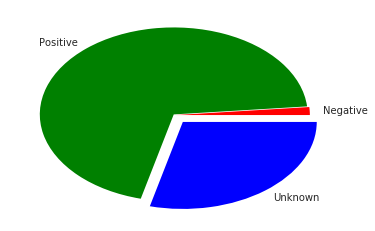

In [4]:
import matplotlib.pyplot as plt
slices = list(Sample.iloc[0,:3])
labels = Sample.columns[:3].tolist()
colors  = ['r','g','b']
print(slices)
print(labels)
plt.pie(slices,labels=labels,colors=colors,explode=[0.01,0.01,0.1])
plt.show()

In [1]:
def GrabSample(limit,offset):
  import google.datalab.storage as storage
  import google.datalab.bigquery as bq
  query = """
  select * 
  from stackoverflowexp.quesansuseransscorenotzero
  limit """ + str(limit)+ """ offset """+str(offset)

  Sample = bq.Query(query).execute().result().to_dataframe()
  return Sample

# Feature Engieering time!
<br><br>
My main method of finding out if an answer is good, is to figure out how closely it resembles the question keywords and the answerers history of answering questions.
<br><br>
let's take out 5 entries to define a feature engineering pipeline


In [7]:
GrabSample(5,0).head()

,Questiontitle,QuestionBody,QuestionCommentCount,QuestionScore,QuestionTags,AnswerBody,AnswerCommentCount,AnswerScore,NumberOfBadges,NumberOfCommentsMade,...,CodedAnswers,Reputation,UpVotes,DownVotes,ProfileViews,HasWebsite,AllTagsAnswered,IsItUseful,IsItAccepted,UsefulOrAccepted
0,Extract diagonals of each 2D square sub-array ...,<p>This is my first programming class and I'm ...,1,0,python|arrays|loops|numpy|diagonal,<p>Your current solution does not work because...,3,3,256,16322,...,4104,102181,5878,3662,29182,False,"[python|dictionary, python|pandas, python|pand...",True,True,True
1,Python: Create two lists from loop and sum both,<p>I'm working on a credit project of CS50 and...,1,0,python|cs50,<p>Write a helper function to sum your digits....,12,1,256,16322,...,4104,102181,5878,3662,29182,False,"[python|dictionary, python|pandas, python|pand...",True,True,True
2,formating strings extracted from a dataframe i...,"<p>In my dataframe , There are several countr...",0,1,python|pandas|dataframe,<p>Use <code>str.extract</code>:</p>\n\n<pre><...,2,1,256,16322,...,4104,102181,5878,3662,29182,False,"[python|dictionary, python|pandas, python|pand...",True,True,True
3,Lemmatizing txt file and replacing only lemmat...,<p>Having trouble figuring out how to lemmatiz...,2,1,python|nltk|lemmatization,<p>Initialise a <code>WordNetLemmatizer</code>...,12,1,256,16322,...,4104,102181,5878,3662,29182,False,"[python|dictionary, python|pandas, python|pand...",True,True,True
4,"Persistent Store - Save, Read and Overwrite data",<p>I am trying to save 10 String values in <co...,0,1,blackberry|persistent|overwrite|persistent-sto...,"<p>If you want a list of 10 messages, I would ...",9,1,256,2369,...,585,29007,3685,414,3271,True,"[objective-c|ios|jailbreak, blackberry|foregro...",True,True,True


### So now we have data, what kind of feature do we need?
<br><br><br><br>
### Here's something:
<br><br>
1. Let's match the keywords from the question to the answers
    - We can see how many of the keywords from the question match the keywords in the answers. turn this into a number
    - We can use NLTK
2. Let's match the tag of the questions to the tags of all the answers the answerer got right before.
    - Just like the previous part, we can use a similar matching algorithm to figure out how many times the user has succesfully answered questions with the same tags
3. Let's use the other question, answer and user attributes
<br><br><br>
Let's define functions for looking at the question/answer matching, title/answer matching and tag matching  

In [2]:
def questionAnswerMatch(strings):
  matches = 0
  from nltk.corpus import stopwords 
  from nltk.tokenize import word_tokenize
  stop_words = set(stopwords.words('english')) 
  word_tokens =  word_tokenize(strings[0].lower().replace("|",' '))
  filtered_question = [w for w in word_tokens if not w in stop_words] 
  word_tokens =  word_tokenize(strings[1].lower().replace("|",' '))
  filtered_answer = [w for w in word_tokens if not w in stop_words] 
  results = {}
  for i in filtered_question:
    results[i] = filtered_answer.count(i)
    
  return sum(results.values())

def tagMatch(lists):
  def filterSeps(list):
    clean = []
    for i in list:
      clean.extend(i.lower().split('|'))
    return clean
  
  questionTags = lists[0].lower().split('|')
  answerTags = filterSeps(lists[1])
  results = {}
  for i in questionTags:
    results[i] = answerTags.count(i)
    
  return sum(results.values())

def wordCount(item):
  if isinstance(item,list):
    items = []
    for i in item:
      items.extend(i.lower().split('|'))
    return len(items)
  else:
    return len(item.lower().split('|'))
  
  
def keyWordCount(item):
  from nltk.corpus import stopwords 
  from nltk.tokenize import word_tokenize
  stop_words = set(stopwords.words('english')) 
  word_tokens =  word_tokenize(item.lower().replace("|",' '))
  filtered_item = [w for w in word_tokens if not w in stop_words]
  #print(filtered_item)
  return len(filtered_item)



### Now let's make another BigQuery table with the features so that we can start training a model
<br><br><br>


In [11]:
Data = GrabSample(100,0)
Data.head()

,Questiontitle,QuestionBody,QuestionCommentCount,QuestionScore,QuestionTags,AnswerBody,AnswerCommentCount,AnswerScore,NumberOfBadges,NumberOfCommentsMade,...,CodedAnswers,Reputation,UpVotes,DownVotes,ProfileViews,HasWebsite,AllTagsAnswered,IsItUseful,IsItAccepted,UsefulOrAccepted
0,Apply groupby on a DataFrame to display cumula...,<p>Let's say I have a DataFrame that looks lik...,4,0,python|pandas|dataframe|group-by|pandas-groupby,<p>You can consider <code>df.groupby</code> wi...,7,3,256,16322,...,4104,102181,5878,3662,29182,False,"[python|dictionary, python|pandas, python|pand...",True,True,True
1,Pass a list of functions with their correspond...,<p>I am struggling to pass a list of functions...,7,3,python|function|kwargs,<p>You could use the function's name as the ke...,8,3,256,16322,...,4104,102181,5878,3662,29182,False,"[python|dictionary, python|pandas, python|pand...",True,True,True
2,Extract middle word of letter python,<p>I have pandas dataframe called df which loo...,2,0,python|string|pandas|split,<p><strong>Option 1</strong><br>\nYou can do i...,5,4,256,16322,...,4104,102181,5878,3662,29182,False,"[python|dictionary, python|pandas, python|pand...",True,True,True
3,PHP referring to object data with numerical key,<p>I have converted an array to object data li...,0,10,php,"<p>That's an oddity in PHP, you need to access...",0,17,256,551,...,530,58840,2698,205,2017,False,"[php|include-path, php|warnings|session-state,...",True,True,True
4,Best practices for reusable embedded C?,<p>I'm writing C code for an embedded system (...,0,11,c|embedded,<p>No.<br>\nNormally you define a path to your...,0,1,256,309,...,37,11706,392,26,1180,False,[c|ffmpeg|video-encoding|libavcodec|libavforma...,True,False,True


## We can apply our engineered feature transformations on the data

In [ ]:
def featureMap(Data):  
  import pandas as pd
  NewData = pd.concat([Data[['QuestionBody','AnswerBody']].apply(questionAnswerMatch,axis=1),
                       Data[['Questiontitle','AnswerBody']].apply(questionAnswerMatch,axis=1),
                       Data[['QuestionTags','AllTagsAnswered']].apply(tagMatch,axis=1),
                       Data['QuestionBody'].apply(keyWordCount),
                       Data['Questiontitle'].apply(keyWordCount),Data['QuestionTags'].apply(wordCount),
                       Data['AnswerBody'].apply(keyWordCount),Data['AllTagsAnswered'].apply(wordCount)],
                      axis=1)
  NewData.columns = ['QuestionBodyAnswerMatch','QuestionTitleAnswerMatch','QuestionUserTagMatch',
                          'QuestionBodyKeyWords','QuestionTitleKeyWords','NumQuestionTags','AnswerKeyWords',
                          'NumUserTags']
  OldData = Data.drop(['Questiontitle', 'QuestionBody','QuestionTags', 'AnswerBody','AnswerScore','AllTagsAnswered','IsItUseful','IsItAccepted'],axis=1)
  NewData = pd.concat([NewData,OldData],axis=1)
  NewData.head()
  return NewData



In [18]:
Data = GrabSample(10,0)
NewData = featureMap(Data)
NewData.head()

,QuestionBodyAnswerMatch,QuestionTitleAnswerMatch,QuestionUserTagMatch,QuestionBodyKeyWords,QuestionTitleKeyWords,NumQuestionTags,AnswerKeyWords,NumUserTags,QuestionCommentCount,QuestionScore,...,NumberOfBadges,NumberOfCommentsMade,NumberOfAnswers,CodedAnswers,Reputation,UpVotes,DownVotes,ProfileViews,HasWebsite,UsefulOrAccepted
0,129,11,6702,353,7,5,160,11704,0,0,...,256,16322,4118,4104,102181,5878,3662,29182,False,True
1,27,1,334,41,6,2,76,1431,1,6,...,256,551,711,530,58840,2698,205,2017,False,True
2,294,7,1067,334,8,2,483,2608,6,2,...,256,3023,1057,1057,51572,6304,2151,8945,False,True
3,237,0,1162,206,2,4,304,2608,1,2,...,256,3023,1057,1057,51572,6304,2151,8945,False,True
4,125,1,295,185,3,2,175,2188,4,0,...,256,4503,999,916,38969,3896,3435,4431,False,True


### So now we have a way of transforming our data into features that can be modelled by an algorithm, and we were able to throw that all into a table in BigQuery. Let's go ahead and do this to the rest of the data and create yet another table in BigQuery

In [2]:
import google.datalab.bigquery as bq
query = """
select countif(AnswerScore<0) as Negative, countif(UsefulOrAccepted=True) as Positive, count(*) - countif(UsefulOrAccepted=True) - countif(AnswerScore<0) as Unknown, count(*) as totalAnswers
from stackoverflowexp.negativeans
"""
Sample = bq.Query(query).execute().result().to_dataframe()

In [ ]:
x = 100
start = 7000
def GrabSample(table,limit,offset):
  import google.datalab.storage as storage
  import google.datalab.bigquery as bq
  query = """
  select * 
  from stackoverflowexp.""" + table+ """ 
  limit """ + str(limit)+ """ offset """+str(offset)

  Sample = bq.Query(query).execute().result().to_dataframe()
  return Sample

def questionAnswerMatch(strings):
  matches = 0
  from nltk.corpus import stopwords 
  from nltk.tokenize import word_tokenize
  stop_words = set(stopwords.words('english')) 
  word_tokens =  word_tokenize(strings[0].lower().replace("|",' '))
  filtered_question = [w for w in word_tokens if not w in stop_words] 
  word_tokens =  word_tokenize(strings[1].lower().replace("|",' '))
  filtered_answer = [w for w in word_tokens if not w in stop_words] 
  results = {}
  for i in filtered_question:
    results[i] = filtered_answer.count(i)
    
  return sum(results.values())

def tagMatch(lists):
  def filterSeps(list):
    clean = []
    for i in list:
      if isinstance(i,str):
        clean.extend(i.lower().split('|'))
    return clean
  if len(lists[1])<=1:
    return 0
  
  questionTags = lists[0].lower().split('|')
  answerTags = filterSeps(lists[1])
  results = {}
  for i in questionTags:
    results[i] = answerTags.count(i)
    
  return sum(results.values())

def wordCount(item):
  if isinstance(item,list):
    items = []
    for i in item:
      if isinstance(i,str):
        items.extend(i.lower().split('|'))
    return len(items)
  else:
    return len(item.lower().split('|'))
  
  
def keyWordCount(item):
  from nltk.corpus import stopwords 
  from nltk.tokenize import word_tokenize
  stop_words = set(stopwords.words('english')) 
  word_tokens =  word_tokenize(item.lower().replace("|",' '))
  filtered_item = [w for w in word_tokens if not w in stop_words]
  #print(filtered_item)
  return len(filtered_item)

def featureMap(Data):  
  import pandas as pd
  NewData = pd.concat([Data[['QuestionBody','AnswerBody']].apply(questionAnswerMatch,axis=1),
                       Data[['Questiontitle','AnswerBody']].apply(questionAnswerMatch,axis=1),
                       Data[['QuestionTags','AllTagsAnswered']].apply(tagMatch,axis=1),
                       Data['QuestionBody'].apply(keyWordCount),
                       Data['Questiontitle'].apply(keyWordCount),Data['QuestionTags'].apply(wordCount),
                       Data['AnswerBody'].apply(keyWordCount),Data['AllTagsAnswered'].apply(wordCount)],
                      axis=1)
  NewData.columns = ['QuestionBodyAnswerMatch','QuestionTitleAnswerMatch','QuestionUserTagMatch',
                          'QuestionBodyKeyWords','QuestionTitleKeyWords','NumQuestionTags','AnswerKeyWords',
                          'NumUserTags']
  OldData = Data.drop(['Questiontitle', 'QuestionBody','QuestionTags', 'AnswerBody','AllTagsAnswered','IsItUseful','IsItAccepted'],axis=1)
  NewData = pd.concat([NewData,OldData],axis=1)
  NewData.head()
  return NewData

from datalab.context import Context
import datalab.bigquery as bq
import pandas as pd
AllData = pd.DataFrame()

for i in range(start,Sample.iloc[0,3],x):
  print(i)
  Data = GrabSample('positiveans',x,i)
  print('DataLoaded')
  NewData = featureMap(Data)
  NewData = NewData.astype(int)
  print('Data Transformed')
  if i==0:
    NewData.to_csv('QuesAnsUserFeats.csv')
  NewData.to_csv('QuesAnsUserFeats.csv', mode='a',header=False)
  Data = GrabSample('negativeans',x,i)
  print('DataLoaded')
  NewData = featureMap(Data)
  NewData = NewData.astype(int)
  print('Data Transformed')
  NewData.to_csv('QuesAnsUserFeats.csv', mode='a',header=False)


### so now the data is in a csv format, we can send this off into BigQuery as a table.
<br><br>

I manually downloaded and uploaded the data through a storage bucket to big query.
<br><br>
### Here comes the model!
<br><br>
Now I can fit a model using Bigquery ML

In [ ]:
%%bq query
#standardSQL
CREATE MODEL `stackoverflowexp.model2`
OPTIONS(input_label_cols=['UsefulOrAccepted'],model_type='logistic_reg',data_split_method='random') AS
SELECT
  *
FROM
  `stackoverflowexp.quesansuserfeats` 

### Now I can check how this model fit

In [ ]:
#standardSQL
WITH eval_table AS (
SELECT
  *
FROM
  `stackoverflowexp.quesansuserfeats`  )
SELECT
  *
FROM
  ML.EVALUATE(MODEL `stackoverflowexp.model2`,
    TABLE eval_table)

precision  0.61

recall  0.59

accuracy  0.60

f1_score  0.60

log_loss  0.68

roc_auc  0.64

